In [1]:
from hana_ml import dataframe as hdf
import pandas as pd

## Load the user connection data and connect to the SAP HANA database instance

Before running the next cell make sure [../0x00-setup/temp_user.ini](../0x00-setup/temp_user.ini) is copied to [../0x00-setup/user.ini](../0x00-setup/user.ini) and the user + password are set appropriately.

In [2]:
from hana_ml.algorithms.pal.utility import Settings
myhost, myport, myuser, mypwd = Settings.load_config("../0x00-setup/user.ini")

In [3]:
myconn=hdf.ConnectionContext(
    address=myhost, 
    port=myport, 
    user=myuser,
    password=mypwd
)
print(f"Connected to SAP HANA db with version: {myconn.hana_version()}")

Connected to SAP HANA db with version: 4.00.000.00.1687267030 (fa/CE2023.16)


In [4]:
print(myconn.sql("SELECT NOW() FROM DUMMY").collect().CURRENT_TIMESTAMP[0])

2023-06-30 12:48:40.729000


# Tables from SAP HANA

In [5]:
hdf_train=myconn.table('TRAIN', schema='TITANIC')

In [6]:
hdf_train.describe().collect()

,column,count,unique,nulls,mean,std,min,max,median,25_percent_cont,25_percent_disc,50_percent_cont,50_percent_disc,75_percent_cont,75_percent_disc
0,PassengerId,891,891,0,446.000000,257.353842,1.00,891.0000,446.0000,223.5000,223.0000,446.0000,446.0000,668.5,669.0
1,Survived,891,2,0,0.383838,0.486592,0.00,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0,1.0
2,PClass,891,3,0,2.308642,0.836071,1.00,3.0000,3.0000,2.0000,2.0000,3.0000,3.0000,3.0,3.0
3,Age,714,88,177,29.699118,14.526497,0.42,80.0000,28.0000,20.1250,20.0000,28.0000,28.0000,38.0,38.0
4,SibSp,891,7,0,0.523008,1.102743,0.00,8.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0,1.0
5,ParCh,891,7,0,0.381594,0.806057,0.00,6.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,0.0
6,Fare,891,248,0,32.204208,49.693429,0.00,512.3292,14.4542,7.9104,7.8958,14.4542,14.4542,31.0,31.0
7,Name,891,891,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,Gender,891,2,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,Ticket,891,681,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
hdf_train.get_table_structure()

{'PassengerId': 'INT',
 'Survived': 'INT',
 'PClass': 'INT',
 'Name': 'NVARCHAR(5000)',
 'Gender': 'NVARCHAR(5000)',
 'Age': 'DOUBLE',
 'SibSp': 'INT',
 'ParCh': 'INT',
 'Ticket': 'NVARCHAR(5000)',
 'Fare': 'DOUBLE',
 'Cabin': 'NVARCHAR(5000)',
 'Embarked': 'NVARCHAR(5000)'}

In [8]:
from hana_ml.visualizers.unified_report import UnifiedReport

In [9]:
UnifiedReport(obj=hdf_train).build(key='PassengerId').display()

/Users/I076835/miniconda3/envs/codejam-hanaml/lib/python3.10/site-packages/hana_ml/visualizers/dataset_report.py:206: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  self.rows_count = int(self.variables_describe.head(1).collect()['count'])


Generating dataset report...: 100%|███████████████████████████████████| 8/8 [00:30<00:00,  3.77s/it]
In order to review the dataset report better, you need to adjust the size of the left area or hide the left area temporarily!


# Categorical and Continuous Variables

Continuous variables are measured numerically, and have an infinite number of possible values.

Categorical variables are also known as discrete or qualitative variables. 

Categorical variables can be further categorized as either nominal or ordinal.



## Univariate Analysis

In [10]:
label = ['Survived']
categorical_features = ['PClass','Gender','Embarked']

In [11]:
from hana_ml.algorithms.pal.stats import univariate_analysis

In [12]:
continuous, categorical = univariate_analysis(
    data=hdf_train,
    key='PassengerId',
    categorical_variable=categorical_features + label,
    significance_level=0.05,
    trimmed_percentage=0.2)

In [13]:
continuous.head(15).collect()

,VARIABLE_NAME,STAT_NAME,STAT_VALUE
0,ParCh,valid observations,891.000000
1,ParCh,min,0.000000
2,ParCh,lower quartile,0.000000
3,ParCh,median,0.000000
4,ParCh,upper quartile,0.000000
5,ParCh,max,6.000000
6,ParCh,mean,0.381594
7,ParCh,"CI for mean, lower bound",0.328595
8,ParCh,"CI for mean, upper bound",0.434593
9,ParCh,trimmed mean,0.065421


In [14]:
continuous.filter(condition="VARIABLE_NAME='Fare'").collect()

,VARIABLE_NAME,STAT_NAME,STAT_VALUE
0,Fare,valid observations,891.000000
1,Fare,min,0.000000
2,Fare,lower quartile,7.895800
3,Fare,median,14.454200
4,Fare,upper quartile,31.000000
5,Fare,max,512.329200
6,Fare,mean,32.204208
7,Fare,"CI for mean, lower bound",28.936831
8,Fare,"CI for mean, upper bound",35.471585
9,Fare,trimmed mean,17.454850


In [15]:
categorical.head(15).collect()

,VARIABLE_NAME,CATEGORY,STAT_NAME,STAT_VALUE
0,Embarked,__PAL_NULL__,count,2.000000
1,Embarked,__PAL_NULL__,percentage(%),0.224467
2,Gender,__PAL_NULL__,count,0.000000
3,Gender,__PAL_NULL__,percentage(%),0.000000
4,Survived,__PAL_NULL__,count,0.000000
5,Survived,__PAL_NULL__,percentage(%),0.000000
6,Survived,0,count,549.000000
7,Embarked,C,count,168.000000
8,Survived,0,percentage(%),61.616162
9,PClass,__PAL_NULL__,count,0.000000


In [16]:
categorical.filter(condition="VARIABLE_NAME='Survived'").collect()

,VARIABLE_NAME,CATEGORY,STAT_NAME,STAT_VALUE
0,Survived,__PAL_NULL__,count,0.000000
1,Survived,__PAL_NULL__,percentage(%),0.000000
2,Survived,0,count,549.000000
3,Survived,0,percentage(%),61.616162
4,Survived,1,count,342.000000
5,Survived,1,percentage(%),38.383838


## Categorical variables evaluation (bar + pie charts)

In [17]:
from hana_ml.visualizers.eda import *
from matplotlib import pyplot as plt

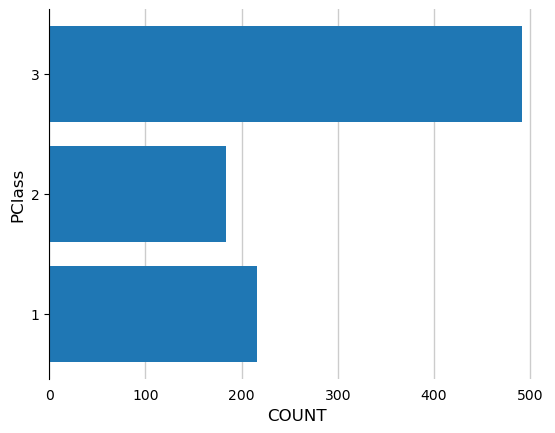

In [18]:
ax, bar_data = EDAVisualizer().bar_plot(data=hdf_train, column='PClass', aggregation={'PClass':'count'})

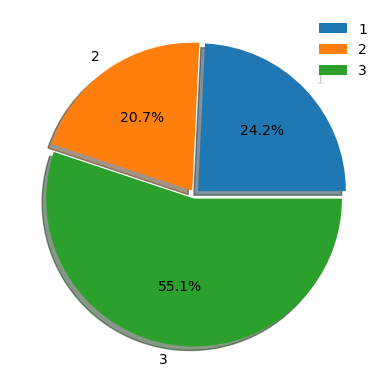

In [19]:
ax, pie_data = EDAVisualizer().pie_plot(data=hdf_train, column='PClass')

## Continuous variables evaluation (histograms + boxplots)

In [20]:
numeric_features = ['Age', 'SibSp', 'ParCh', 'Fare']

In [21]:
from hana_ml.visualizers import eda

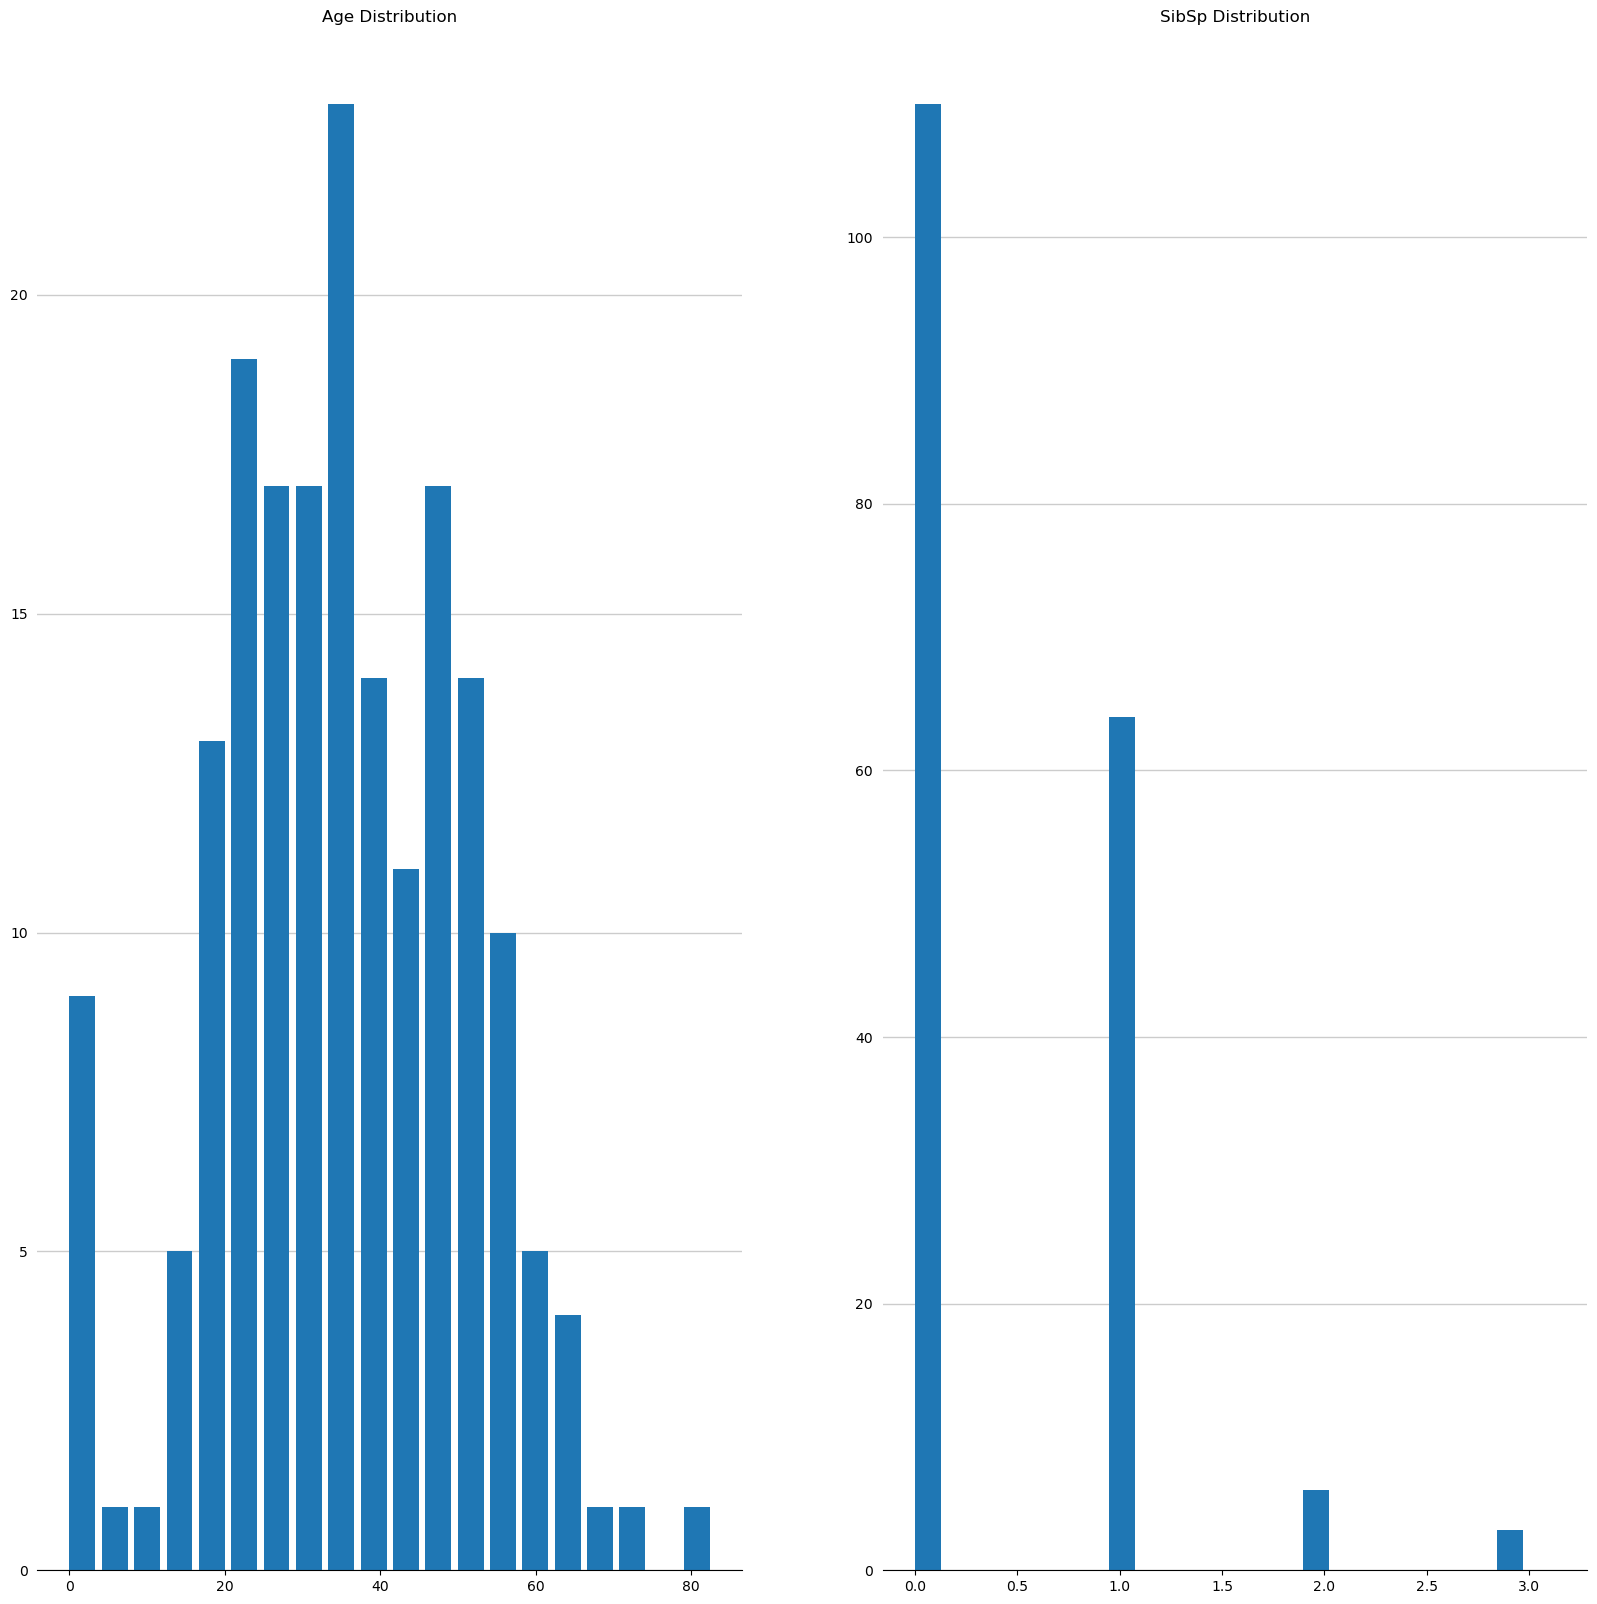

In [22]:
eda.hist(data=hdf_train.dropna(), columns=['Age', 'SibSp'], default_bins=20)

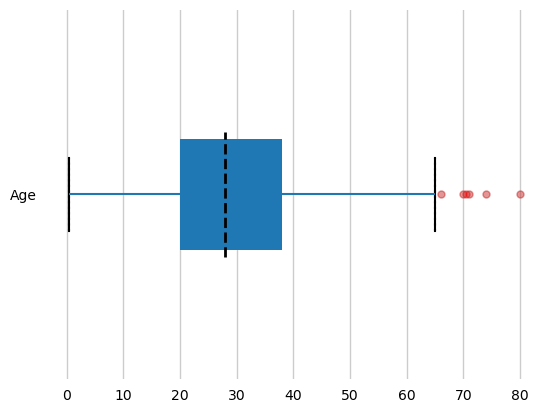

In [23]:
_, bp = EDAVisualizer().box_plot(
    data=hdf_train.dropna(subset=['Age']), column='Age',
    legend=False, outliers=True
)

#### Output combined charts as one

TransformedBbox(
    Bbox(x0=0.0, y0=0.0, x1=6.4, y1=4.8),
    Affine2D().scale(100.0))


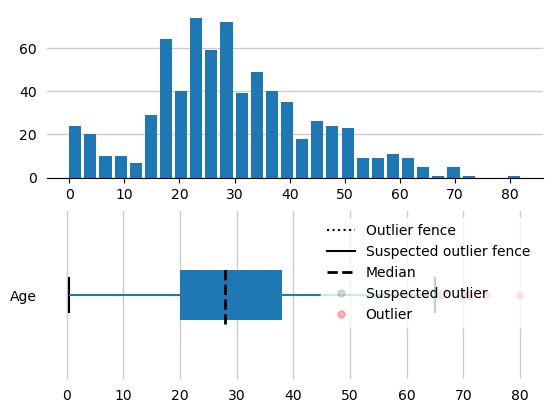

In [24]:
fig = plt.figure() #figsize=(10,5))
print (fig.figbbox)
ax1 = fig.add_subplot(211)
eda1 = EDAVisualizer(ax=ax1)
ax1, dist_data = eda1.distribution_plot(data=hdf_train.dropna(subset=['Age']), column="Age", bins=30)
# plt.show()
ax2 = fig.add_subplot(212)
eda2 = EDAVisualizer(ax=ax2)
ax2, corr_data = eda2.box_plot(data=hdf_train.dropna(subset=['Age']), column='Age', outliers=True)


## Bivariate Analysis

### Box plot with `group by`

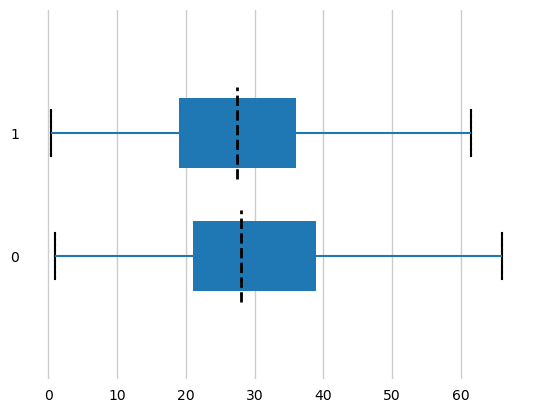

In [25]:
_ = EDAVisualizer().box_plot(
    data=hdf_train.dropna(subset=['Age']), column='Age',
    legend=False, outliers=False, groupby='Survived'
)

# MVA

(<Axes: >,
           PClass      Fare       Age
 ID                                  
 PClass  1.000000 -0.554182 -0.369226
 Fare   -0.554182  1.000000  0.096067
 Age    -0.369226  0.096067  1.000000)

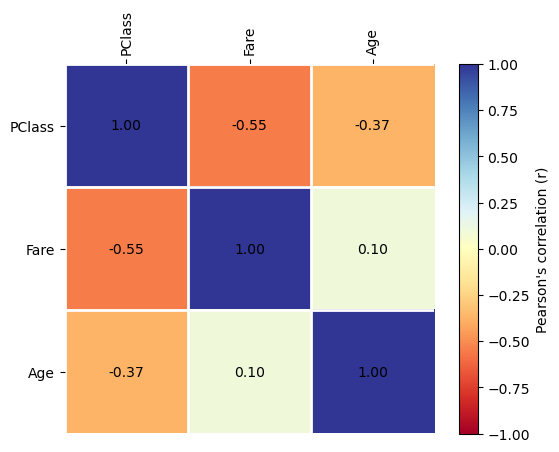

In [29]:
EDAVisualizer().correlation_plot(
    data=hdf_train, corr_cols=['PClass', 'Fare', 'Age'],
    #cmap='bwr'
)

#Note the use of color pallets, best: diverging colormaps